In [72]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os

In [73]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v,num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h+(freq[i]/num)*np.log2(freq[i]/num)
    h = -h
    return h

def entropy1(v, num, offset):
    freq = np.zeros(offset)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(offset):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed
def entropy_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file,8*i)
    return h_vector

def entropy_analysis1(file, Bytes, offset):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy1(file, 8*i, offset)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, size):
    vec = np.zeros(size)
    for i in range(size):
        vec[i] = int.from_bytes(bytes(file[i], 'latin-1'), byteorder="big")
    return vec

def file_to_vector1(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

# Return a vector containing ones, if for different header lengths correctly classify a file, and 0.0 otherwise. y is the correct result (True or False),
def accuracies(threshold, areas, y):
    accuracies=np.zeros([len(areas),1], dtype=float)
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
    return accuracies

def accuracies1(threshold, areas, offset_org, y):
    accuracies = np.zeros([int(offset_org/8),1], dtype=float)
    true_positives = 0
    true_negatives = 0
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
            true_negatives += 1
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
            true_positives += 1
    return accuracies, true_positives, true_negatives

#analyze the differential area of file_vector from the byte at position start to the byte at position end
def trapezoidal_rule(ideal_file, file_vector):
    area = np.zeros(33)
    # Iterate over the different header lenghts of the file
    for i in range(8, 257, 8):
        h_ideal = entropy_analysis(ideal_file, i)
        h = entropy_analysis(file_vector, i)
        area[int(i/8)] = diff_area(h_ideal,h)
    return area

def trapezoidal_rule1(ideal_file, file_vector, offset):
    area = np.zeros(int(offset/8))
    # Iterate over the different header lenghts of the file
    for i in range(8, offset + 1, 8):
        h_ideal = entropy_analysis1(ideal_file, i, offset)
        h = entropy_analysis1(file_vector, i, offset)
        area[int(i/8)-1] = diff_area(h_ideal,h)
    return area

Now we set all the parameters of our detection mechanism

In [74]:
static_offset = 256
dynamic_offset = static_offset

true_positives=0
true_negatives=0

ideal_file = np.zeros(static_offset)
for i in range(len(ideal_file)):
    ideal_file[i]=i

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('./paths/ransomware_paths_full.txt', 'r')
paths = f.readlines()
thresholds = np.arange(8,80,2)
f.close()

In [75]:
import time
start_time = time.time()

acc = np.zeros([len(thresholds), len(paths), int(static_offset/8), 1], dtype = float)

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        if len(file) < static_offset:
            dynamic_offset = len(file)
        else:
            dynamic_offset = static_offset
        start = randint(0, len(file) - dynamic_offset)
        file_vector = file_to_vector1(file, start, dynamic_offset)
        area = trapezoidal_rule1(ideal_file, file_vector, dynamic_offset)
        # Check if the file is really encrypted by a ransom and sum to the previous errors releted to the different header lengths the current ones,
        # storing the values
        # Iterate over different threshold values
        for i in range(len(thresholds)):
            if paths[j][19:24] == "EXTRA":
                # acc[i][j] is a vector of offset/8 values, each value represent the (TP + TN) for the differents header lengths of all the files in paths[j][:-1]
                results = accuracies1(thresholds[i], area, static_offset, True)
                acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                true_positives += results[1]
                true_negatives += results[2]
            else:
                results = accuracies1(thresholds[i], area, static_offset, False)
                acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                true_positives += results[1]
                true_negatives += results[2]
    # acc[i][j] is a vector of 33 values, each value represent the accuracies for the differents header lengths of all the files in paths[j][:-1]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    acc[i][j] = np.multiply(np.true_divide(acc[i][j], float(len(files))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes and %s seconds ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1))

Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny-repeat-ciphertext
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny-low-entropy-bytes
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny-low-entropy-bytes
Start analysizng the dir

In [76]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code
acc_reshaped = acc.reshape(np.shape(acc)[0]*np.shape(acc)[1],np.shape(acc)[2])
np.save("./accuracies/accuracies_rand_fragm_analysis_countr_256.npy", acc_reshaped, fix_imports=False)

In [77]:
# deserialize the tensor from the file .npy
acc_des=np.load('./accuracies/accuracies_rand_fragm_analysis_countr_256.npy')
acc_des = acc_des.reshape(len(thresholds), len(paths), int(static_offset/8))

In [91]:
# tot_files = 95+100+2800+100+100+200+100+100
# tot_hl = int(static_offset/8)
# tot_thresholds = len(thresholds)
# tot_analyses = tot_files * (tot_hl + tot_thresholds)
print("Total true positives:", true_positives)
print("Total true negatives:", true_negatives)

Total true positives: 1810779
Total true negatives: 487812


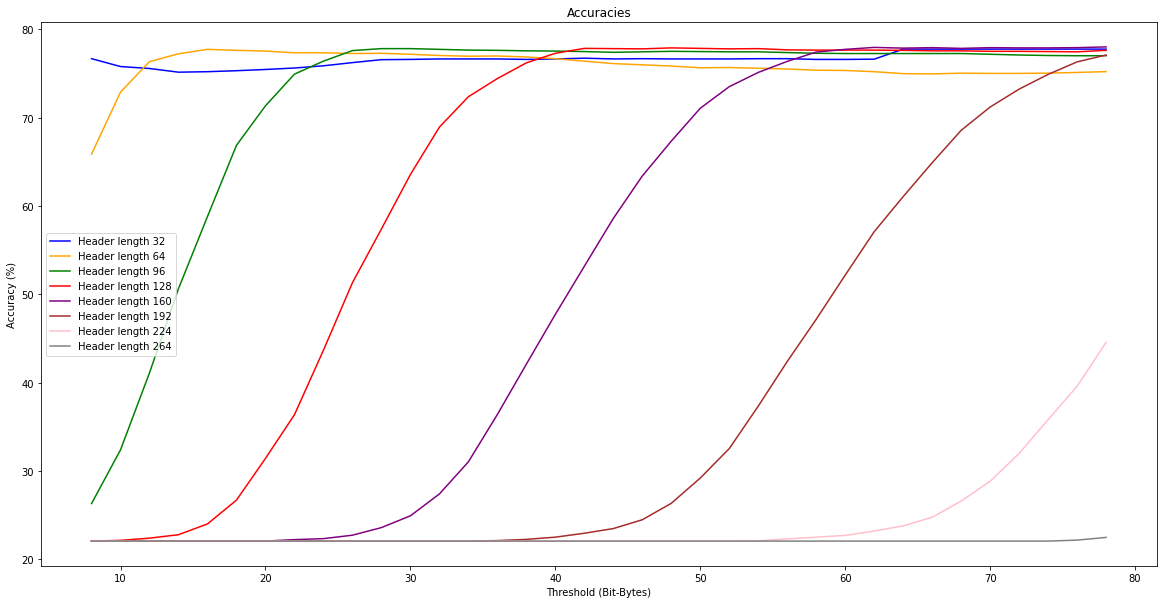

In [89]:
# Get for each threshold and header length the total amount of accuracies
hl_thresh = np.divide(np.sum(acc_des, axis=(1)), np.shape(acc_des)[1]).transpose()

# Plot of the accuracies obtained using different threshold and different header lengths
plt.figure(figsize=(20,10))
plt.title("Accuracies")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Accuracy (%)")
plt.plot(thresholds, hl_thresh[3], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[7], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[11], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[15], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[19], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[23], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[27], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[31], color="grey", label="Header length 256")
plt.legend()
plt.show()